In [2]:
from datetime import datetime 
import functools
import glob
import h5py
import matplotlib
from matplotlib import animation, cm, transforms, pyplot as plt, gridspec as grd
from matplotlib.collections import PathCollection
import numba
import numpy as np
from ripser import Rips, ripser
from scipy import stats, signal, optimize
from scipy.optimize import minimize
import scipy.io as sio
from scipy.ndimage import gaussian_filter,  gaussian_filter1d, rotate, binary_dilation, binary_closing
from scipy.stats import binned_statistic_2d, pearsonr, multivariate_normal
from scipy.special import factorial
from scipy.spatial.distance import cdist, pdist, squareform
import scipy.stats
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score
import sys
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans,DBSCAN
from sklearn.base import BaseEstimator, ClusterMixin,TransformerMixin
from sklearn.metrics import pairwise_distances
import umap
import matplotlib.pyplot as plt
import torch
import os
import plotly.graph_objects as go
from utils import get_coords, plot_diagrams

Code from Erik

In [3]:
def get_symmetric_weights(rows, cols, vals):
    weights = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
    weights.eliminate_zeros()
    transpose = weights.transpose()
    prod_matrix = weights.multiply(transpose)
    weights = (weights + transpose - prod_matrix)
    weights.eliminate_zeros()
    return weights.toarray()

@numba.njit(parallel=True, fastmath=True) 
def compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos):
    n_samples = knn_indices.shape[0]
    n_neighbors = knn_indices.shape[1]
    rows = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_samples * n_neighbors), dtype=np.float64)
    for i in range(n_samples):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))
                #val = ((knn_dists[i, j] - rhos[i]) / (sigmas[i]))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    return rows, cols, vals

## Note, the following funtion is imported from the UMAP library
@numba.njit(
    fastmath=True
)  # benchmarking `parallel=True` shows it to *decrease* performance
def smooth_knn_dist(distances, k, n_iter=64, local_connectivity=0.0, bandwidth=1.0):
    target = np.log2(k) * bandwidth
#    target = np.log(k) * bandwidth
#    target = k
    
    rho = np.zeros(distances.shape[0])
    result = np.zeros(distances.shape[0])

    mean_distances = np.mean(distances)

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = np.inf
        mid = 1.0

        # TODO: This is very inefficient, but will do for now. FIXME
        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        if non_zero_dists.shape[0] >= local_connectivity:
            index = int(np.floor(local_connectivity))
            interpolation = local_connectivity - index
            if index > 0:
                rho[i] = non_zero_dists[index - 1]
                if interpolation > 1e-5:
                    rho[i] += interpolation * (
                        non_zero_dists[index] - non_zero_dists[index - 1]
                    )
            else:
                rho[i] = interpolation * non_zero_dists[0]
        elif non_zero_dists.shape[0] > 0:
            rho[i] = np.max(non_zero_dists)

        for n in range(n_iter):

            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                if d > 0:
                    psum += np.exp(-(d / mid))
#                    psum += d / mid
 
                else:
                    psum += 1.0
#                    psum += 0

            if np.fabs(psum - target) < 1e-5:
                break

            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == np.inf:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0
        result[i] = mid
        # TODO: This is very inefficient, but will do for now. FIXME
        if rho[i] > 0.0:
            mean_ith_distances = np.mean(ith_distances)
            if result[i] < 1e-3 * mean_ith_distances:
                result[i] = 1e-3 * mean_ith_distances
        else:
            if result[i] < 1e-3 * mean_distances:
                result[i] = 1e-3 * mean_distances

    return result, rho

def plot_diagrams(
    diagrams,
    plot_only=None,
    title=None,
    xy_range=None,
    labels=None,
    colormap="default",
    colormap1 = "default",
    size=20,
    ax_color=np.array([0.0, 0.0, 0.0]),
    diagonal=True,
    lifetime=False,
    rel_life= False,
    legend=True,
    show=False,
    ax=None,
    torus_colors = [],
    lw = 2.5,
    cs = ['#1f77b4','#ff7f0e', '#2ca02c', '#d62728']

):


    ax = ax or plt.gca()
    plt.style.use(colormap)

    xlabel, ylabel = "Birth", "Death"

    if labels is None:
        # Provide default labels for diagrams if using self.dgm_
        labels = [
            "$H_0$",
            "$H_1$",
            "$H_2$",
            "$H_3$",
            "$H_4$",
            "$H_5$",
            "$H_6$",
            "$H_7$",
            "$H_8$",
        ]

    if not isinstance(diagrams, list):
        # Must have diagrams as a list for processing downstream
        diagrams = [diagrams]

    if len(plot_only)>0:
        diagrams = [diagrams[i] for i in plot_only]
        labels = [labels[i] for i in plot_only]

    if not isinstance(labels, list):
        labels = [labels] * len(diagrams)

    # Construct copy with proper type of each diagram
    # so we can freely edit them.
    diagrams = [dgm.astype(np.float32, copy=True) for dgm in diagrams]
    aspect = 'equal'
    # find min and max of all visible diagrams
    concat_dgms = np.concatenate(diagrams).flatten()
    has_inf = np.any(np.isinf(concat_dgms))
    finite_dgms = concat_dgms[np.isfinite(concat_dgms)]

    if not xy_range:
        # define bounds of diagram
        ax_min, ax_max = np.min(finite_dgms), np.max(finite_dgms)
        x_r = ax_max - ax_min

        # Give plot a nice buffer on all sides.
        # ax_range=0 when only one point,
        buffer = 1 if xy_range == 0 else x_r / 5

        x_down = ax_min - buffer / 2
        x_up = ax_max + buffer

        y_down, y_up = x_down, x_up
    else:
        x_down, x_up, y_down, y_up = xy_range

    yr = y_up - y_down



    if lifetime:

        # Don't plot landscape and diagonal at the same time.
        diagonal = False

        # reset y axis so it doesn't go much below zero
        y_down = -yr * 0.05
        y_up = y_down + yr

        # set custom ylabel
        ylabel = "Lifetime"

        # set diagrams to be (x, y-x)
        for dgm in diagrams:
            dgm[:, 1] -= dgm[:, 0]

        # plot horizon line
#        ax.plot([x_down, x_up], [0, 0], c=ax_color)

    # Plot diagonal
    if diagonal:
        ax.plot([x_down, x_up], [x_down, x_up], "--", c=ax_color)

    # Plot inf line
    if has_inf:
        # put inf line slightly below top
        b_inf = y_down + yr * 0.95
        # convert each inf in each diagram with b_inf
        for dgm in diagrams:
            dgm[np.isinf(dgm)] = b_inf

    # Plot each diagram
    i = 0
    for dgm, label in zip(diagrams, labels):
        c = cs[plot_only[i]]
        # plot persistence pairs
        ax.scatter(dgm[:, 0], dgm[:, 1], size, label=label, edgecolor="none", c = c)
        i += 1
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
    if len(torus_colors)>0:
        births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
        deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
        deaths1[np.isinf(deaths1)] = 0
        #lives1 = deaths1-births1
        #inds1 = np.argsort(lives1)
        inds1 = np.argsort(deaths1)
        ax.scatter(diagrams[1][inds1[-1], 0], diagrams[1][inds1[-1], 1], 
                   10*size, linewidth =lw, edgecolor=torus_colors[0], facecolor = "none")
        ax.scatter(diagrams[1][inds1[-2], 0], diagrams[1][inds1[-2], 1], 
                   10*size, linewidth =lw, edgecolor=torus_colors[1], facecolor = "none")
        
        
        births2 = diagrams[2][:, ] #the time of birth for the 1-dim classes
        deaths2 = diagrams[2][:, 1] #the time of death for the 1-dim classes
        deaths2[np.isinf(deaths2)] = 0
        #lives2 = deaths2-births2
        #inds2 = np.argsort(lives2)
        inds2 = np.argsort(deaths2)
#        print(lives2, births2[inds2[-1]],deaths2[inds2[-1]], diagrams[2][inds2[-1], 0], diagrams[2][inds2[-1], 1])
        ax.scatter(diagrams[2][inds2[-1], 0], diagrams[2][inds2[-1], 1], 
                   10*size, linewidth =lw, edgecolor=torus_colors[2], facecolor = "none")
        
        
    ax.set_xlim([x_down, x_up])
    ax.set_ylim([y_down, y_up])
    ax.set_aspect(aspect, 'box')

    if title is not None:
        ax.set_title(title)

    if legend is True:
        ax.legend(loc="upper right")

    if show is True:
        plt.show()
    return

Import the data. "activity" is then a 40000x512 matrix with all activations.

In [4]:
activity = torch.load("activations/ILSVRC2015/inception4a.pt").detach().numpy()
print(activity.shape)

(50761, 512)


Use UMap to project to 2D

In [5]:
#Fixing umap bug. https://gitmetadata.com/repo/lmcinnes/pynndescent/issues/163

@numba.njit(fastmath=True)
def correct_alternative_cosine(ds):
    result = np.empty_like(ds)
    for i in range(ds.shape[0]):
        result[i] = 1.0 - np.power(2.0, ds[i])
    return result


import pynndescent
pynn_dist_fns_fda = pynndescent.distances.fast_distance_alternatives
pynn_dist_fns_fda["cosine"]["correction"] = correct_alternative_cosine
pynn_dist_fns_fda["dot"]["correction"] = correct_alternative_cosine

In [6]:
layout_2d = umap.UMAP(n_components=2, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(activity)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_neighbors=20, verbose=True)
Wed Feb  9 17:56:13 2022 Construct fuzzy simplicial set
Wed Feb  9 17:56:13 2022 Finding Nearest Neighbors
Wed Feb  9 17:56:13 2022 Building RP forest with 16 trees
Wed Feb  9 17:56:14 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Wed Feb  9 17:56:20 2022 Finished Nearest Neighbor Search
Wed Feb  9 17:56:21 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Feb  9 17:56:43 2022 Finished embedding


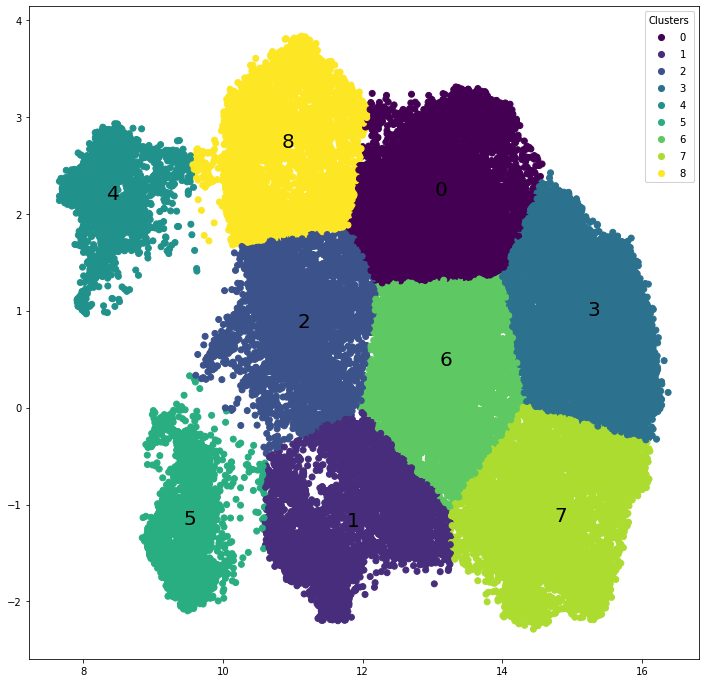

In [7]:
kmeans=KMeans(9, random_state=42)
clusters=kmeans.fit_predict(layout_2d)
#clusters=kmeans.fit_predict(activity)
centroids=kmeans.cluster_centers_

#plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(x=layout_2d[:,0],y=layout_2d[:,1], c=clusters)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

for i in range(max(clusters)+1):
    plt.annotate(i,(centroids[i,0], centroids[i,1]), size=20)
plt.show()

In [17]:
layout = umap.UMAP(n_components=512, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(activity)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=512, n_neighbors=20, verbose=True)
Wed Feb  9 18:26:19 2022 Construct fuzzy simplicial set
Wed Feb  9 18:26:19 2022 Finding Nearest Neighbors
Wed Feb  9 18:26:19 2022 Building RP forest with 16 trees
Wed Feb  9 18:26:20 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Wed Feb  9 18:26:22 2022 Finished Nearest Neighbor Search
Wed Feb  9 18:26:23 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Feb  9 18:34:27 2022 Finished embedding


Cluster the UMap output with kMeans to get 10 cluster. Then visualize.

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_neighbors=20, verbose=True)
Wed Feb  9 18:35:18 2022 Construct fuzzy simplicial set
Wed Feb  9 18:35:18 2022 Finding Nearest Neighbors
Wed Feb  9 18:35:18 2022 Building RP forest with 16 trees
Wed Feb  9 18:35:18 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Wed Feb  9 18:35:21 2022 Finished Nearest Neighbor Search
Wed Feb  9 18:35:21 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Feb  9 18:35:43 2022 Finished embedding


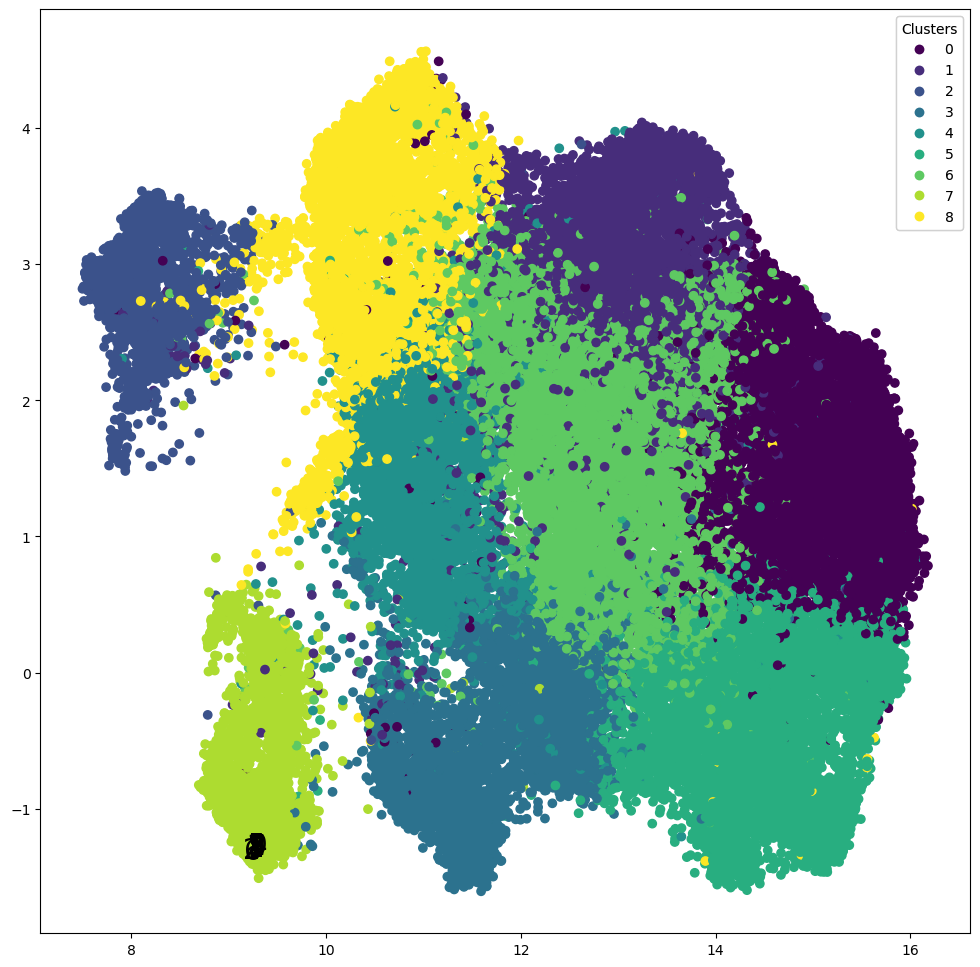

In [18]:
kmeans=KMeans(9, random_state=42)
clusters=kmeans.fit_predict(layout)
#clusters=kmeans.fit_predict(activity)
centroids=kmeans.cluster_centers_
points = np.concatenate((activity, centroids), axis=0)
layout_2d = umap.UMAP(n_components=2, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(points)

#plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(x=layout_2d[:activity.shape[0],0],y=layout_2d[:activity.shape[0],1], c=clusters)
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

for i in range(max(clusters)+1):
    plt.annotate(i,(layout_2d[activity.shape[0]+ i,0], layout_2d[activity.shape[0]+ i,1]), size=20)
plt.show()

In cluster 7 there is a circle in the activations. To see it we apply UMAp as a prepocessing step. Then it's visible with persistent homology. 

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=512, n_neighbors=20, verbose=True)
Wed Feb  9 19:06:30 2022 Construct fuzzy simplicial set
Wed Feb  9 19:06:36 2022 Finding Nearest Neighbors
Wed Feb  9 19:06:36 2022 Finished Nearest Neighbor Search
Wed Feb  9 19:06:37 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb  9 19:06:59 2022 Finished embedding


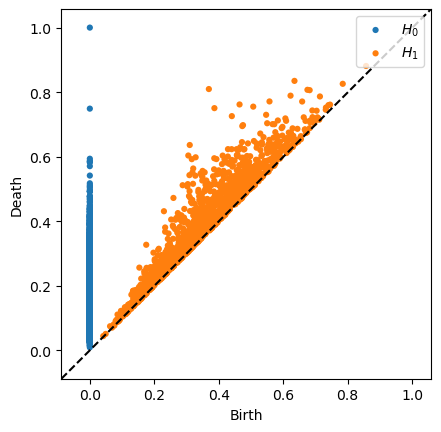

In [19]:
cluster=[]
for n in range(len(clusters)):
    if clusters[n] in [4]:
        cluster.append(activity[n])
cluster = np.array(cluster)

layout2 = umap.UMAP(n_components=512, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(cluster)
M = squareform(pdist(layout2, 'euclidean'))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix = True, thresh = thresh)
plt.figure()
plot_diagrams(
    persistence["dgms"],
    plot_only=np.arange(maxdim+1))
plt.show()


More code from Erik to compute a circular parameter:

In [20]:
def get_coords(cocycle, threshold, num_sampled, dists, coeff):
    zint = np.where(coeff - cocycle[:, 2] < cocycle[:, 2])
    cocycle[zint, 2] = cocycle[zint, 2] - coeff
    d = np.zeros((num_sampled, num_sampled))
    d[np.tril_indices(num_sampled)] = np.NaN
    d[cocycle[:, 1], cocycle[:, 0]] = cocycle[:, 2]
    d[dists > threshold] = np.NaN
    d[dists == 0] = np.NaN
    edges = np.where(~np.isnan(d))
    verts = np.array(np.unique(edges))
    num_edges = np.shape(edges)[1]
    num_verts = np.size(verts)
    values = d[edges]
    A = np.zeros((num_edges, num_verts), dtype=int)
    v1 = np.zeros((num_edges, 2), dtype=int)
    v2 = np.zeros((num_edges, 2), dtype=int)
    for i in range(num_edges):
        v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
        v2[i, :] = [i, np.where(verts == edges[1][i])[0]]
    A[v1[:, 0], v1[:, 1]] = -1
    A[v2[:, 0], v2[:, 1]] = 1
  
    L = np.ones((num_edges,))
    Aw = A * np.sqrt(L[:, np.newaxis])
    Bw = values * np.sqrt(L)
    f = lsmr(Aw, Bw)[0]%1
    return f, verts

Use the code to compute a circular parameter for the identified circle using circular parametrization (de Silva):

In [21]:
diagrams = persistence["dgms"] # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][1] # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
lives1 = deaths1-births1 # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]])*(9/10)
    
cocycle = cocycles[iMax[-1]]

f, verts = get_coords(cocycle,threshold,len(layout2),M,47)

print(len(f))

/var/folders/dv/2b73qfmn5rv5r60s5j4vz8dr0000gn/T/ipykernel_64864/4138112373.py:18: DeprecationWarning:

setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.

/var/folders/dv/2b73qfmn5rv5r60s5j4vz8dr0000gn/T/ipykernel_64864/4138112373.py:19: DeprecationWarning:

setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.



 
LSMR            Least-squares solution of  Ax = b

The matrix A has 244890 rows and 3527 columns
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =     3527

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.311e+01  5.919e+01   1.0e+00  3.4e-01
     1  0.00000e+00  8.780e+00  2.054e+01   6.7e-01  3.9e-01  6.0e+00  1.0e+00
     2  0.00000e+00  8.243e+00  1.346e+01   6.3e-01  1.7e-01  9.5e+00  1.0e+00
     3  0.00000e+00  7.947e+00  8.560e+00   6.1e-01  7.4e-02  1.4e+01  1.4e+00
     4  0.00000e+00  7.836e+00  6.549e+00   6.0e-01  4.7e-02  1.8e+01  1.4e+00
     5 -1.70857e-06  7.748e+00  5.299e+00   5.9e-01  3.2e-02  2.1e+01  1.9e+00
     6 -9.25884e-06  7.682e+00  4.266e+00   5.9e-01  2.3e-02  2.5e+01  1.7e+00
     7 -2.59778e-05  7.636e+00  3.512e+00   5.8e-01  1.7e-02  2.8e+01  1.8e+00
     8 -5.19403e-05  7.605e+00  2.979e+00   5.8e-01  1.3e-02  3.1e+01  1.8e+00

Visualize it after projecting to 3d: 

In [22]:
layout_3d = umap.UMAP(n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(cluster)

fig = go.Figure(data=[go.Scatter3d(x=layout_3d[:,0], y=layout_3d[:,1],z=layout_3d[:,2],mode='markers',marker=dict(size=12,color=f,colorscale='Viridis',opacity=0.8,showscale=True))])
fig.update_layout(autosize=False,width=1000,
    height=700,margin=dict(l=0, r=0, b=0, t=0))
fig.write_html("circular_feature_3D.html")
fig.show()

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Wed Feb  9 19:11:07 2022 Construct fuzzy simplicial set
Wed Feb  9 19:11:13 2022 Finding Nearest Neighbors
Wed Feb  9 19:11:13 2022 Finished Nearest Neighbor Search
Wed Feb  9 19:11:13 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb  9 19:11:15 2022 Finished embedding


Not all neurons contribute equally to this circle. We identify the ones that tune to it: 

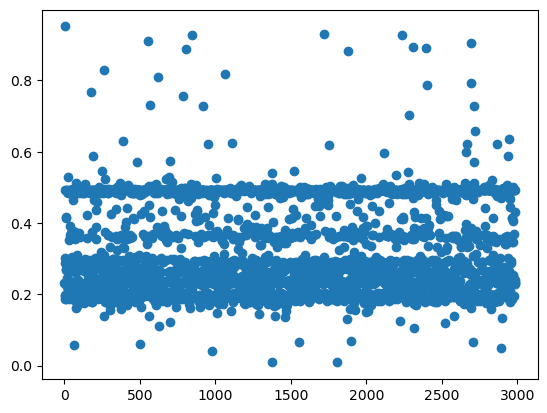

In [25]:
plt.scatter(y=f, x=verts)

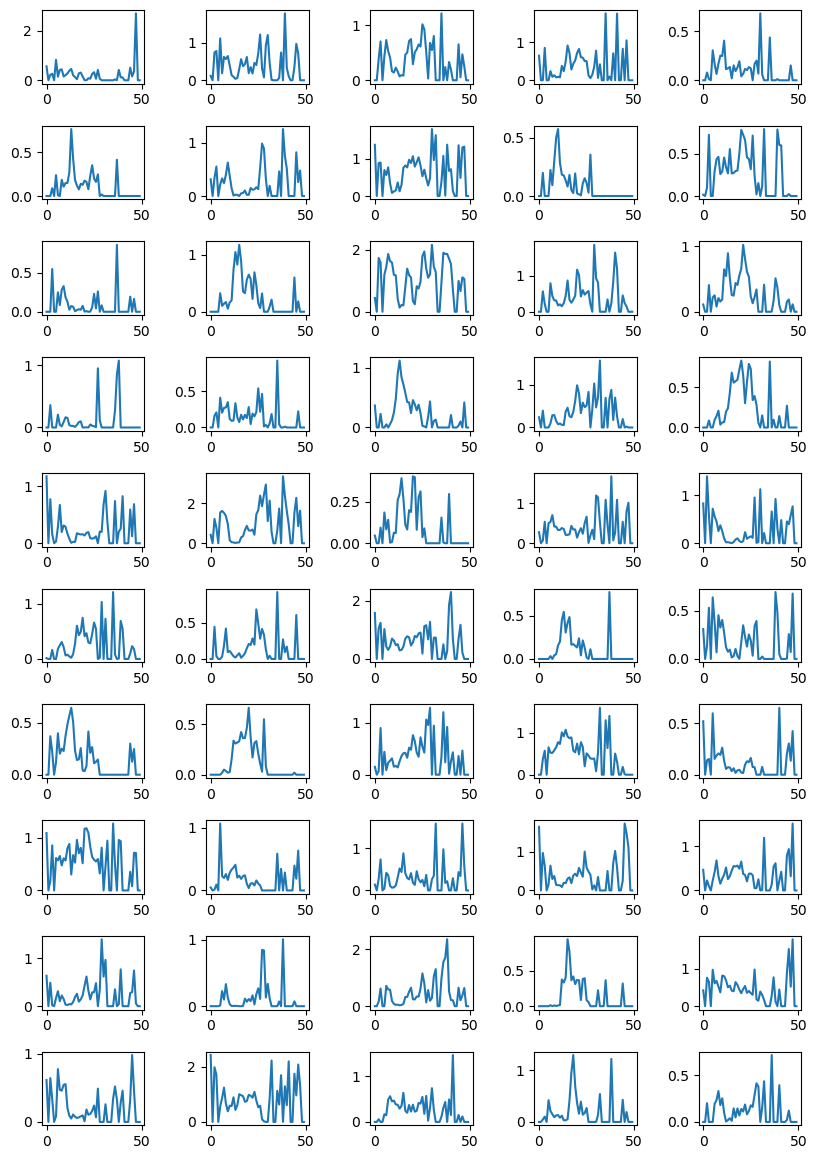

In [27]:
circ_rates = np.zeros([512,50])
bins = np.linspace(0,1,51)
for b in range(len(bins)-1):
    for n in range(512):
        rates = []
        for x in range(len(cluster)):
            if bins[b] < f[x] <= bins[b+1]:
                rates.append(cluster[x,n])
        if rates:
            circ_rates[n,b] = np.mean(rates)
        else:
            circ_rates[n,b] = 0
        
fig, axs = plt.subplots(10,5,figsize=(8.27,11.69))
for n in range(5):
    for m in range(10):
        axs[m, n].plot(range(50),circ_rates[m*5+n])
fig.tight_layout()

To quantify this we compute the information rate of the neurons:

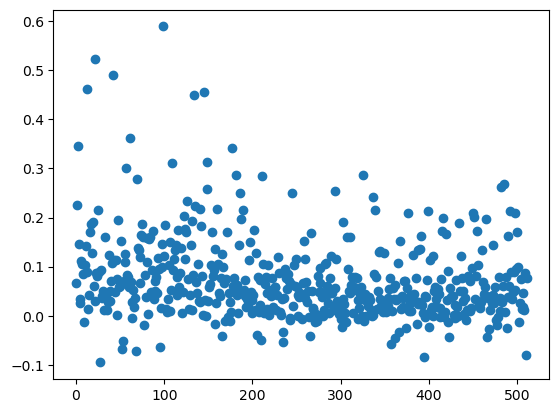

In [28]:
def inform_rate(mean_n,data,coun):
    m=[]
    for b in range(50):
        m.append(data[b])
    return np.sum(m*np.log2((m/mean_n)+0.0000001)*coun)

mean = np.zeros(512)
for n in range(512):
    mean[n] = np.mean(cluster[:,n])

counts=[]
for b in range(50):
    count=0
    for p in f:
        if b/51 < p < (b+1)/51:
            count+=1
    counts.append(count/len(f))

inform_rates= []
for n in range(512):
    inform_rates.append(inform_rate(mean[n],circ_rates[n,:],counts))
    
plt.scatter(range(len(inform_rates)),inform_rates)

Then we pick the ones with an information rate higher then 0.2:

In [29]:
high_inform = np.where(np.array(inform_rates)>0.2)[0]
len(high_inform)

38

Lets compute everything again but just with these neurons:

In [30]:
cluster_new = cluster[:,np.where(np.array(inform_rates)>0.2)[0]]
data_new = activity[:,np.where(np.array(inform_rates)>0.2)[0]]

layout_3d_cluster = umap.UMAP(n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(cluster_new)



UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Wed Feb  9 01:09:24 2022 Construct fuzzy simplicial set
Wed Feb  9 01:09:26 2022 Finding Nearest Neighbors
Wed Feb  9 01:09:26 2022 Finished Nearest Neighbor Search
Wed Feb  9 01:09:26 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb  9 01:09:28 2022 Finished embedding


In [31]:
cluster_new_crop = cluster_new[np.where(np.array(layout_3d_cluster)[:,0]>3)[0],:]
layout_3d_new = umap.UMAP(n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(cluster_new_crop)


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Wed Feb  9 01:09:41 2022 Construct fuzzy simplicial set
Wed Feb  9 01:09:42 2022 Finding Nearest Neighbors
Wed Feb  9 01:09:42 2022 Finished Nearest Neighbor Search
Wed Feb  9 01:09:42 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb  9 01:09:44 2022 Finished embedding


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=38, n_neighbors=20, verbose=True)
Wed Feb  9 01:09:48 2022 Construct fuzzy simplicial set
Wed Feb  9 01:09:49 2022 Finding Nearest Neighbors
Wed Feb  9 01:09:49 2022 Finished Nearest Neighbor Search
Wed Feb  9 01:09:49 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Feb  9 01:09:52 2022 Finished embedding


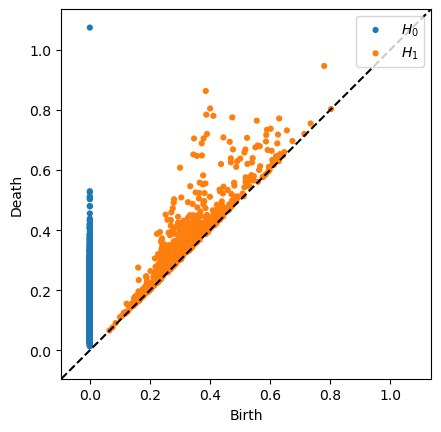

/var/folders/dv/2b73qfmn5rv5r60s5j4vz8dr0000gn/T/ipykernel_63140/248947481.py:18: DeprecationWarning:

setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.

/var/folders/dv/2b73qfmn5rv5r60s5j4vz8dr0000gn/T/ipykernel_63140/248947481.py:19: DeprecationWarning:

setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.



2015

In [32]:
layout3 = umap.UMAP(n_components=len(high_inform), verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(cluster_new_crop)
M = squareform(pdist(layout3, 'euclidean'))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix = True, thresh = thresh)
plt.figure()
plot_diagrams(
    persistence["dgms"],
    plot_only=np.arange(maxdim+1))
plt.show()
                    
diagrams = persistence["dgms"] # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][1] # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
lives1 = deaths1-births1 # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]])*(9/10)
    
cocycle = cocycles[iMax[-1]]

f_new = get_coords(cocycle,threshold,len(layout3),M,47)

len(f_new[0])                    

In [33]:
fig = go.Figure(data=[go.Scatter3d(x=layout_3d_new[:,0], y=layout_3d_new[:,1],z=layout_3d_new[:,2],mode='markers',marker=dict(size=12,color=f_new[0],colorscale='Viridis',opacity=0.8,showscale=True))])
fig.update_layout(autosize=False,width=1000,
    height=700,margin=dict(l=0, r=0, b=0, t=0))
fig.write_html("circular_feature_3D.html")
fig.show()

We visulize the circle using using the lucent library. For that end we calculate average activation vectors for 50 overlapping patches along the circular parameter, Then we visulize those 50 average activation vectors. 

In [38]:
linsp = np.linspace(0,1,51)

clusters_overlap = []
for a in range(1,50):
    c = []
    for p in range(len(f_new[0])):
        if linsp[a-1] < f_new[0][p] < linsp[a+1]:
            c.append(cluster_new_crop[p])
    print(linsp[a-1])
    print(linsp[a+1])
    clusters_overlap.append(c)
c=[]
for p in range(len(f)):
    if linsp[49] < f[p] or f[p] < linsp[1]:
            c.append(cluster_new_crop[p])
print(linsp[49])
print(linsp[1])
clusters_overlap.append(c)

av_clusters_overlap = []
for p in range(len(clusters_overlap)):
    av_clusters_overlap.append(np.mean(clusters_overlap[p],axis=0))

0.0
0.04
0.02
0.06
0.04
0.08
0.06
0.1
0.08
0.12
0.1
0.14
0.12
0.16
0.14
0.18
0.16
0.2
0.18
0.22
0.2
0.24
0.22
0.26
0.24
0.28
0.26
0.3
0.28
0.32
0.3
0.34
0.32
0.36
0.34
0.38
0.36
0.4
0.38
0.42
0.4
0.44
0.42
0.46
0.44
0.48
0.46
0.5
0.48
0.52
0.5
0.54
0.52
0.56
0.54
0.58
0.56
0.6
0.58
0.62
0.6
0.64
0.62
0.66
0.64
0.68
0.66
0.7000000000000001
0.68
0.72
0.7000000000000001
0.74
0.72
0.76
0.74
0.78
0.76
0.8
0.78
0.8200000000000001
0.8
0.84
0.8200000000000001
0.86
0.84
0.88
0.86
0.9
0.88
0.92
0.9
0.9400000000000001
0.92
0.96
0.9400000000000001
0.98
0.96
1.0
0.98
0.02


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████| 512/512 [00:50<00:00, 10.15it/s]



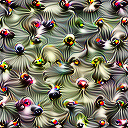

100%|█████████████████████████████████████████| 512/512 [01:03<00:00,  8.05it/s]



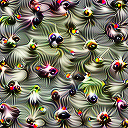

100%|█████████████████████████████████████████| 512/512 [00:50<00:00, 10.05it/s]



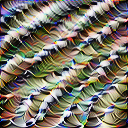

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.98it/s]



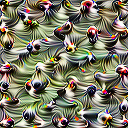

100%|█████████████████████████████████████████| 512/512 [00:52<00:00,  9.75it/s]



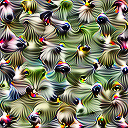

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.72it/s]



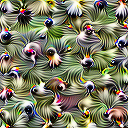

100%|█████████████████████████████████████████| 512/512 [00:50<00:00, 10.06it/s]



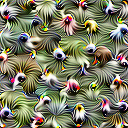

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.75it/s]



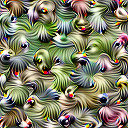

100%|█████████████████████████████████████████| 512/512 [00:55<00:00,  9.31it/s]



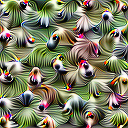

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.68it/s]



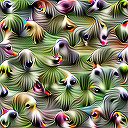

100%|█████████████████████████████████████████| 512/512 [00:55<00:00,  9.14it/s]



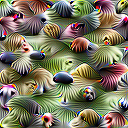

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.78it/s]



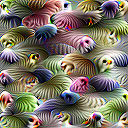

100%|█████████████████████████████████████████| 512/512 [00:53<00:00,  9.53it/s]



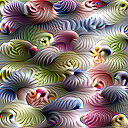

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.77it/s]



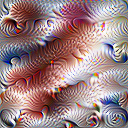

100%|█████████████████████████████████████████| 512/512 [00:54<00:00,  9.40it/s]



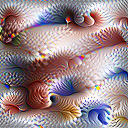

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.81it/s]



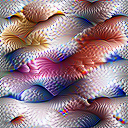

100%|█████████████████████████████████████████| 512/512 [00:51<00:00,  9.88it/s]



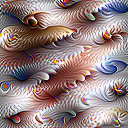

100%|█████████████████████████████████████████| 512/512 [01:01<00:00,  8.32it/s]



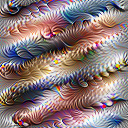

100%|█████████████████████████████████████████| 512/512 [00:55<00:00,  9.26it/s]



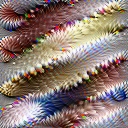

100%|█████████████████████████████████████████| 512/512 [01:07<00:00,  7.57it/s]



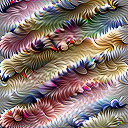

100%|█████████████████████████████████████████| 512/512 [00:54<00:00,  9.34it/s]



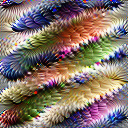

100%|█████████████████████████████████████████| 512/512 [01:08<00:00,  7.43it/s]



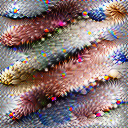

100%|█████████████████████████████████████████| 512/512 [00:53<00:00,  9.59it/s]



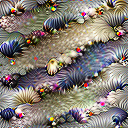

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.88it/s]



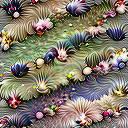

100%|█████████████████████████████████████████| 512/512 [00:57<00:00,  8.86it/s]



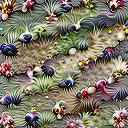

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.80it/s]



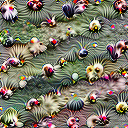

100%|█████████████████████████████████████████| 512/512 [00:56<00:00,  9.07it/s]



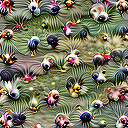

100%|█████████████████████████████████████████| 512/512 [01:07<00:00,  7.54it/s]



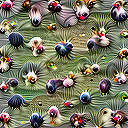

100%|█████████████████████████████████████████| 512/512 [00:56<00:00,  9.04it/s]



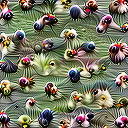

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.88it/s]



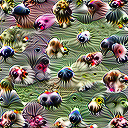

100%|█████████████████████████████████████████| 512/512 [00:56<00:00,  9.14it/s]



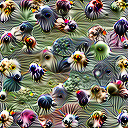

100%|█████████████████████████████████████████| 512/512 [01:08<00:00,  7.48it/s]



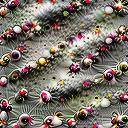

100%|█████████████████████████████████████████| 512/512 [00:57<00:00,  8.97it/s]



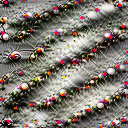

100%|█████████████████████████████████████████| 512/512 [01:08<00:00,  7.48it/s]



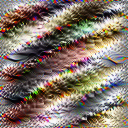

100%|█████████████████████████████████████████| 512/512 [00:55<00:00,  9.19it/s]



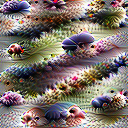

100%|█████████████████████████████████████████| 512/512 [01:31<00:00,  5.59it/s]



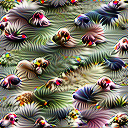

100%|█████████████████████████████████████████| 512/512 [03:26<00:00,  2.48it/s]



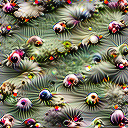

100%|█████████████████████████████████████████| 512/512 [01:01<00:00,  8.38it/s]



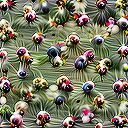

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.73it/s]



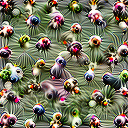

100%|█████████████████████████████████████████| 512/512 [00:58<00:00,  8.82it/s]



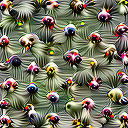

100%|█████████████████████████████████████████| 512/512 [00:54<00:00,  9.47it/s]



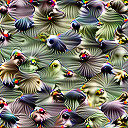

100%|█████████████████████████████████████████| 512/512 [01:01<00:00,  8.29it/s]



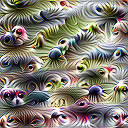

100%|█████████████████████████████████████████| 512/512 [00:51<00:00,  9.94it/s]



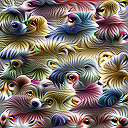

100%|█████████████████████████████████████████| 512/512 [01:00<00:00,  8.52it/s]



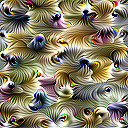

100%|█████████████████████████████████████████| 512/512 [00:55<00:00,  9.29it/s]



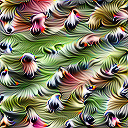

100%|█████████████████████████████████████████| 512/512 [00:56<00:00,  9.00it/s]



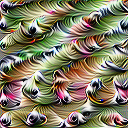

100%|█████████████████████████████████████████| 512/512 [01:08<00:00,  7.43it/s]



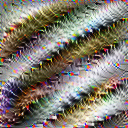

100%|█████████████████████████████████████████| 512/512 [00:58<00:00,  8.76it/s]



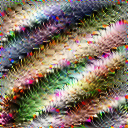

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.69it/s]



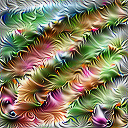

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.74it/s]



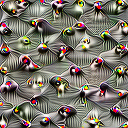

In [39]:
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()

pics =[]
channel = lambda n: objectives.channel("inception4a", n)
for n in range(len(av_clusters_overlap)):
    a=[]
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics.append(d)

100%|██████████| 512/512 [01:32<00:00,  5.51it/s]



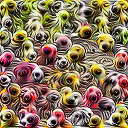

In [49]:
a=[]
for m in range(len(high_inform)):
    a.append(av_clusters_overlap[49][m] * channel(high_inform[m]))
obj = sum(a)
d = render.render_vis(model, obj, show_inline=True)

In [48]:
len(av_clusters_overlap)

50